# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True



### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model_L1 = ConvNet()
model_CE=ConvNet()
model_CEL=ConvNet()
model_FL2=ConvNet()
model_FL12=ConvNet()
model_FL4=ConvNet()
model_list=[model_L1,model_CE,model_CEL,model_FL2,model_FL12,model_FL4]
for i in range(len(model_list)):
    model_list[i].to(device)

### Optimizer

In [7]:
optimizer_list=[]
scheduler_list=[]
for i in range(len(model_list)):
    optimizer = optim.SGD(model_list[i].parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
    optimizer_list.append(optimizer)
    scheduler_list.append(scheduler)

In [8]:
#define class for focal loss
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward (self, output, target):
        sum=0
        gamma=self.gamma
        for i in range(len(output)):
            prob=F.softmax(output[i],dim=0)[target[i]]
            focal_loss=-torch.pow(1-prob,gamma)*torch.log(prob)
            sum+=focal_loss
        return sum/len(output)
        


In [9]:
#loss function

loss_function=["L1Loss","CrossEntropyLoss","CrossEntropyLoss(lable_smoothing=0.1)","Focal loss(gamma=2)","Focal loss(gamma=0.5)","Focal loss(gamma=4)"]
def loss_chosen(LOSS_CHOSEN):
    if LOSS_CHOSEN==0:
        criterion=nn.L1Loss()
    elif LOSS_CHOSEN==1:
        criterion=nn.CrossEntropyLoss()
    elif LOSS_CHOSEN==2:
        criterion=nn.CrossEntropyLoss(label_smoothing=0.2)
    elif LOSS_CHOSEN==3:
        criterion=FocalLoss(2)
    elif LOSS_CHOSEN==4:
        criterion=FocalLoss(0.5)
    elif LOSS_CHOSEN==5:
        criterion=FocalLoss(4)
    return criterion
    


In [10]:
def train_batch(model, image, target,criterion):
   
    output = model(image)
    if LOSS_CHOSEN==0:
        output_softmax=F.softmax(output,dim=1)
        target_one_hot=F.one_hot(target,NUM_CLASS)
        loss=criterion(output_softmax,target_one_hot)
    else :
        loss=criterion(output,target)

    return output, loss

In [11]:

def test_batch(model, image, target,criterion):
    
    output = model(image)
    if LOSS_CHOSEN==0:
        output_softmax=F.softmax(output,dim=1)
        target_one_hot=F.one_hot(target,NUM_CLASS)
        loss=criterion(output_softmax,target_one_hot)
    else :
        loss=criterion(output,target)
    

    return output, loss

### Model Training

In [12]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

L1_test=torch.zeros(10,10)
CE_test=torch.zeros(10,10)
CEL_test=torch.zeros(10,10)
Focal2_test=torch.zeros(10,10)
Focal12_test=torch.zeros(10,10)
Focal4_test=torch.zeros(10,10)
matrics_test=[L1_test,CE_test,CEL_test,Focal2_test,Focal12_test,Focal4_test]

for i in range(len(loss_function)):
    LOSS_CHOSEN=i
    criterion=loss_chosen(LOSS_CHOSEN)
    model=model_list[LOSS_CHOSEN]
    print("使用的损失函数:"+loss_function[i])
    optimizer=optimizer_list[i]
    scheduler=optimizer_list[i]
    
    matric_test=matrics_test[i]
    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

         ##########################
         ### Training
         ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

             # train model
            outputs, loss = train_batch(model, image, target,criterion)
            _, preds = torch.max(outputs, 1)
            
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                 raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)
        

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc.cpu().detach().numpy())

         # change learning rate
        scheduler.step()


         ##########################
         ### Testing
         ##########################
         # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

                 # test model
            outputs, loss = test_batch(model, image, target,criterion)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            for p in range(len(target)):
                matric_test[target[p]][preds[p]]+=1
                
            
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
             # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
             'state_dict': model.state_dict(),
             'acc': epoch_acc,
             'epoch': (epoch+1),
            }

                 # check the dir
            if not os.path.exists(SAVE_DIR):
                 os.makedirs(SAVE_DIR)

                 # save the state
            torch.save(state, osp.join(SAVE_DIR, loss_function[i]+'checkpoint_%s.pth' % (str(epoch+1))))

使用的损失函数:L1Loss
Epoch: 1/30 Train Loss: 0.0014 Acc: 0.1472
Begin test......
Test Loss: 0.0012 Acc: 0.2156
Epoch: 2/30 Train Loss: 0.0012 Acc: 0.2438
Begin test......
Test Loss: 0.0011 Acc: 0.2764
Epoch: 3/30 Train Loss: 0.0011 Acc: 0.2739
Begin test......
Test Loss: 0.0011 Acc: 0.3080
Epoch: 4/30 Train Loss: 0.0011 Acc: 0.2905
Begin test......
Test Loss: 0.0011 Acc: 0.3240
Epoch: 5/30 Train Loss: 0.0011 Acc: 0.3014
Begin test......
Test Loss: 0.0010 Acc: 0.3423
Epoch: 6/30 Train Loss: 0.0011 Acc: 0.3131
Begin test......
Test Loss: 0.0010 Acc: 0.3442
Epoch: 7/30 Train Loss: 0.0011 Acc: 0.3222
Begin test......
Test Loss: 0.0010 Acc: 0.3477
Epoch: 8/30 Train Loss: 0.0011 Acc: 0.3229
Begin test......
Test Loss: 0.0010 Acc: 0.3627
Epoch: 9/30 Train Loss: 0.0010 Acc: 0.3316
Begin test......
Test Loss: 0.0010 Acc: 0.3604
Epoch: 10/30 Train Loss: 0.0010 Acc: 0.3362
Begin test......
Test Loss: 0.0010 Acc: 0.3725
Epoch: 11/30 Train Loss: 0.0010 Acc: 0.3395
Begin test......
Test Loss: 0.0010 Acc: 

In [30]:
L1=torch.zeros(10,10)
CE=torch.zeros(10,10)
CEL=torch.zeros(10,10)
Focal2=torch.zeros(10,10)
Focal12=torch.zeros(10,10)
Focal4=torch.zeros(10,10)
matrics=[L1,CE,CEL,Focal2,Focal12,Focal4]
for md in range(len(model_list)):
    print(loss_function[md])
    model=ConvNet()
    model.to(device)
    checkpoint = torch.load(osp.join(SAVE_DIR, loss_function[md]+'checkpoint_%s.pth' % (str(30))))
    model.load_state_dict(checkpoint['state_dict'])
    LOSS_CHOSEN=md
    criterion=loss_chosen(md)
    matric=matrics[md]
    for ep in range(1):
        for batch_idx, (image, target) in enumerate(test_dataloader):
            image = image.to(device)
            target = target.to(device)
            outputs, loss = test_batch(model, image, target,criterion)
            _, preds = torch.max(outputs, 1)
            for p in range(len(target)):
                matric[target[p]][preds[p]]+=1
    print(matric)


L1Loss
tensor([[719.,  84.,  26.,   0.,   2.,  22.,  38.,  22.,   0.,  87.],
        [148., 466.,   4.,   0.,   4.,  21.,  72.,  20.,   0., 265.],
        [174.,  36., 196.,   0., 117., 159., 205.,  62.,   0.,  51.],
        [ 89.,  34.,  80.,   0.,  40., 305., 271.,  78.,   0., 103.],
        [ 79.,  19.,  59.,   0., 250., 119., 331., 107.,   0.,  36.],
        [ 89.,  17.,  86.,   0.,  44., 443., 175.,  92.,   0.,  54.],
        [ 17.,  18.,  29.,   0.,  36.,  68., 751.,  22.,   0.,  59.],
        [ 74.,  23.,  37.,   0.,  56., 122., 110., 469.,   0., 109.],
        [595., 143.,  12.,   0.,   0.,  24.,  17.,  16.,   0., 193.],
        [163.,  94.,  13.,   0.,   2.,  15.,  75.,  32.,   0., 606.]])
CrossEntropyLoss
tensor([[506.,  22.,  24.,   7.,  23.,  31.,  35.,  37., 213., 102.],
        [ 46., 304.,  15.,   5.,   8.,  21.,  42.,  40., 132., 387.],
        [ 85.,  19., 215.,  20., 146., 152., 177.,  85.,  57.,  44.],
        [ 37.,  19.,  82.,  64., 120., 322., 111., 139.,  39.,  6

In [29]:
for ma in range(len(matrics)):
    print(loss_function[ma])
    matric=matrics[ma]
    for row in range(10):
        col_one=matric[row][row]
        sum=0
        for col in range(10):
            sum+=matric[row][col]
        out=col_one/sum
        print("the recall of class "+class_names[row]+" is:"+str(out.item()))

L1Loss
the recall of class airplane is:0.718999981880188
the recall of class automobile is:0.4659999907016754
the recall of class bird is:0.19599999487400055
the recall of class cat is:0.0
the recall of class deer is:0.25
the recall of class dog is:0.4429999887943268
the recall of class frog is:0.7509999871253967
the recall of class horse is:0.4690000116825104
the recall of class ship is:0.0
the recall of class truck is:0.6060000061988831
CrossEntropyLoss
the recall of class airplane is:0.5059999823570251
the recall of class automobile is:0.30399999022483826
the recall of class bird is:0.2150000035762787
the recall of class cat is:0.06400000303983688
the recall of class deer is:0.3089999854564667
the recall of class dog is:0.44200000166893005
the recall of class frog is:0.5130000114440918
the recall of class horse is:0.5109999775886536
the recall of class ship is:0.5230000019073486
the recall of class truck is:0.6179999709129333
CrossEntropyLoss(lable_smoothing=0.1)
the recall of class

In [28]:
for mat in range(len(matrics)):
    print(loss_function[mat])
    matric=matrics[mat]
    for col1 in range(10):
        row_one=matric[col1][col1]
        sum=0
        for row1 in range(10):
            sum+=matric[row1][col1]
        outc=row_one/sum
        print("the precision of class "+class_names[col1]+" is:"+str(outc.item()))
        

L1Loss
the precision of class airplane is:0.3348858952522278
the precision of class automobile is:0.49892932176589966
the precision of class bird is:0.361623615026474
the precision of class cat is:nan
the precision of class deer is:0.4537205100059509
the precision of class dog is:0.3412942886352539
the precision of class frog is:0.3672371506690979
the precision of class horse is:0.509782612323761
the precision of class ship is:nan
the precision of class truck is:0.3877159357070923
CrossEntropyLoss
the precision of class airplane is:0.4534050226211548
the precision of class automobile is:0.6373165845870972
the precision of class bird is:0.32674771547317505
the precision of class cat is:0.29767441749572754
the precision of class deer is:0.3005836606025696
the precision of class dog is:0.34237024188041687
the precision of class frog is:0.4100719392299652
the precision of class horse is:0.39953088760375977
the precision of class ship is:0.44892704486846924
the precision of class truck is:0

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [13]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [14]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################

#probabilities = F.softmax(model(input.to(device)),dim=1)
#predict_label = torch.argmax(probabilities,dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:


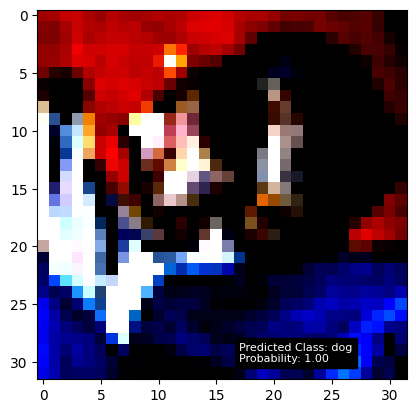

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


L1Loss
airplane: 0.0000
automobile: 0.0000
bird: 0.0000
cat: 0.0000
deer: 0.0000
dog: 1.0000
frog: 0.0000
horse: 0.0000
ship: 0.0000
truck: 0.0000


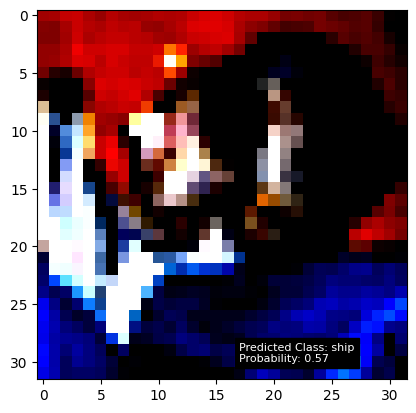

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CrossEntropyLoss
airplane: 0.1180
automobile: 0.0336
bird: 0.0635
cat: 0.0766
deer: 0.0305
dog: 0.0287
frog: 0.0514
horse: 0.0051
ship: 0.5659
truck: 0.0266


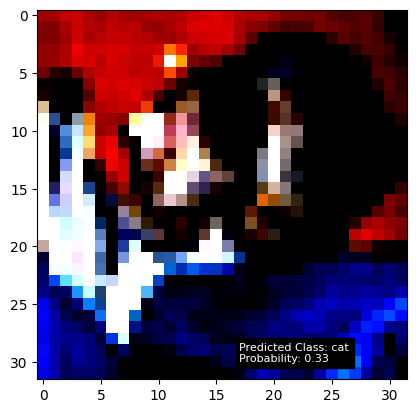

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CrossEntropyLoss(lable_smoothing=0.1)
airplane: 0.0261
automobile: 0.0417
bird: 0.0469
cat: 0.3332
deer: 0.0595
dog: 0.1618
frog: 0.0951
horse: 0.0635
ship: 0.1019
truck: 0.0703


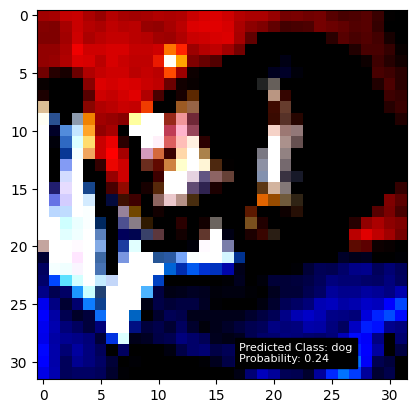

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Focal loss(gamma=2)
airplane: 0.0735
automobile: 0.0386
bird: 0.0868
cat: 0.1669
deer: 0.1055
dog: 0.2353
frog: 0.0920
horse: 0.0693
ship: 0.0906
truck: 0.0415


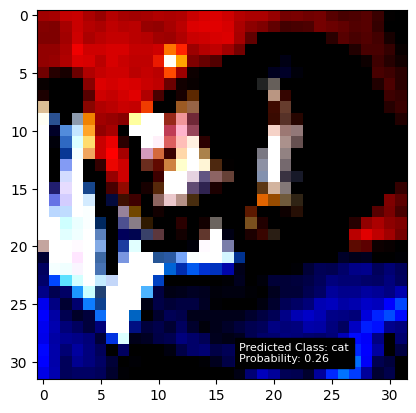

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Focal loss(gamma=0.5)
airplane: 0.0407
automobile: 0.0471
bird: 0.1405
cat: 0.2613
deer: 0.0918
dog: 0.1345
frog: 0.1108
horse: 0.0797
ship: 0.0549
truck: 0.0388


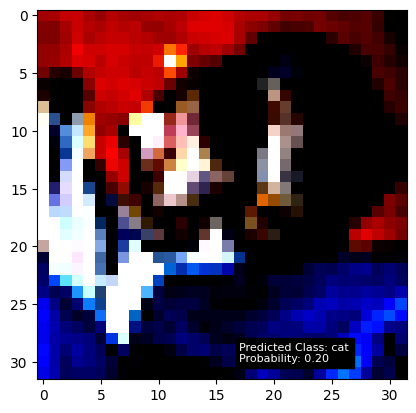

Focal loss(gamma=4)
airplane: 0.0435
automobile: 0.0793
bird: 0.1160
cat: 0.1972
deer: 0.1090
dog: 0.0840
frog: 0.1963
horse: 0.0504
ship: 0.0774
truck: 0.0470


In [31]:
#predicted_class = class_names[predict_label.item()]
#predicted_probability = probabilities[0][predict_label].item()
image = input.numpy().transpose((1, 2, 0))
#plt.imshow(image)
#plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            #color='white', backgroundcolor='black', fontsize=8)
#plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for j in range(len(loss_function)):
    model=model_list[j]
    probabilities = F.softmax(model(input.to(device)),dim=1)
    predict_label = torch.argmax(probabilities,dim=1)
    predicted_class = class_names[predict_label.item()]
    predicted_probability = probabilities[0][predict_label].item()
    plt.imshow(image)
    plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
    plt.show()
    print(loss_function[j])
    for i in range(len(class_names)):
        print(f'{class_names[i]}: {probabilities[0][i].item():.4f}')